# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2022/23 (6 CFU) - Dr. Jacopo Pegoraro, Dr. Daniele Mari
---


# Residual Neural Networks

**Residual neural network (ResNet).** ResNet have been introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf) to effectively train deep neural networks. In fact, deep neural networks can represent very complex functions but in practice, are hard to train. 

**In this assignment, you will:**
- Implement the basic building blocks of ResNets 
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification. 

The dataset is shared here https://drive.google.com/drive/folders/1fAnEoHWYetbyO5-grMmvabGjLUMgrS-Q?usp=share_link


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls
! cp /content/drive/MyDrive/dataset_nndl/camelyon* ./
! mv camelyonpatch_level_2_split_test_y.h5.gz.gzip  camelyonpatch_level_2_split_test_y.h5.gz
! mv camelyonpatch_level_2_split_valid_y.h5.gz.gzip  camelyonpatch_level_2_split_valid_y.h5.gz
! mv camelyonpatch_level_2_split_train_y.h5.gz.gzip  camelyonpatch_level_2_split_train_y.h5.gz
! gzip -df camelyonpatch_level_2_split_test_x.h5.gz 
! gzip -df camelyonpatch_level_2_split_test_y.h5.gz 
! gzip -df camelyonpatch_level_2_split_valid_x.h5.gz 
! gzip -df camelyonpatch_level_2_split_valid_y.h5.gz
! gzip -df camelyonpatch_level_2_split_train_x.h5.gz 
! gzip -df camelyonpatch_level_2_split_train_y.h5.gz

drive  sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset
For this lab you will use the [**PatchCamelyon** dataset](https://github.com/basveeling/pcam). It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue.
A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. 

In this notebook you will use a smaller version of the dataset that consists of 1.200 images. Feel free to download the entire dataset to experiment with it (e.g., if you train the network with more examples, the performance of the designed classifier should increase).


In [ ]:
from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter
import torch
import os
import pandas as pd
import h5py
import random
import numpy as np

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
transforms = Compose([
    ToTensor(), #this converts numpy or Pil image to torch tensor and normalizes it in 0, 1
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(),
    RandomVerticalFlip()
])

In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
class ImageDataset(Dataset):

    def __init__(self, dataset_folder, dataset_type, transform=None):
        self.x = h5py.File(os.path.join(dataset_folder, f'camelyonpatch_level_2_split_{dataset_type}_x.h5'), 'r')['x']
        self.y = h5py.File(os.path.join(dataset_folder, f'camelyonpatch_level_2_split_{dataset_type}_y.h5'), 'r')['y']
        self.transform = transform
    
    def __len__(self):
        return min(32000, len(self.x))
        #return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx, 0, 0].astype(float)
        if self.transform:
            x = self.transform(x)
        return x, y

In [ ]:
train_dataset =  ImageDataset("./", "train", transforms)
valid_dataset =  ImageDataset("./", "valid", ToTensor())
test_dataset =  ImageDataset("./", "test", ToTensor())

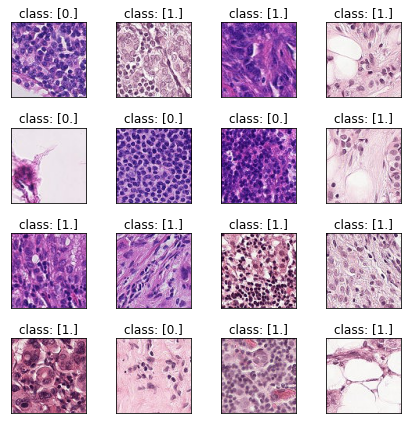

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i in range(16):
    axs[i//4][i%4].imshow(train_dataset[i][0].permute(1, 2, 0).numpy())
    axs[i//4][i%4].set_xticks([])
    axs[i//4][i%4].set_yticks([])
    axs[i//4][i%4].set_title(f"class: {train_dataset[i][1]}")
plt.tight_layout()

In [ ]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())

# Residual Networks
In recent years, neural networks have become deeper, with state-of-the-art networks going from just a few layers to over a hundred layers.

* The main benefits of deep networks are that they can represent very complex functions and learn features at different levels of abstraction, from edges (at the shallower layers, closer to the input) to very complex features (at the deeper layers, closer to the output). 
* However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent slow. 
* More specifically, during gradient descent, as you backpropagate from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values). 

Residual networks try to solve this problem by using skip connections as explained in the next section.

## 1 - Building blocks and construction

In ResNets, a "shortcut" or a "skip connection" allows the model to skip layers:  

<img src="https://theaisummer.com/static/8d19d048cd68d6dce362e025cf3b635a/1ac66/skip-connection.png" scale="50%">
<caption><center> A ResNet block showing a skip-connection <br> </center></caption>


Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different. You are going to implement both of them: the "identity block" and the "convolutional block."

### 1.1 - The identity block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation ($a^{[l]}$) has the same dimension as the output activation ($a^{[l+2]}$).
In this exercise, you will implement an identity block in which the skip connection "skips over" 3 hidden layers:

<img src="https://datascience-enthusiast.com/figures/idblock3_kiank.png" width="1000px">
<caption><center> Identity block. Skip connection "skips over" 2 layers. </center></caption>

The upper path is the "shortcut path". The lower path is the "main path" with convolutional layers and ReLu activation functions. As introduced in the other laboratories, to speed up training we also add BatchNorm layers.  

Here are the individual steps.

**First component** of main path: 
- CONV2D with $F_1$ filters of shape (1, 1), stride of (1, 1), padding "valid". Use 0 as the seed for the random initialization to reproduce the expected output. If you want, you can add a name to the layer using the `name basis` and adding a string for each layer. It can be useful to visualize and clearly identify the different layers in the network. For this layer you can use, e.g., `conv_name_base + '1st'`.
- BatchNorm, normalizing the 'channels' axis.  Example of name: `bn_name_base + '1st'`.
- ReLU activation function. 

**Second component** of main path:
- CONV2D with $F_2$ filters of shape $(f, f)$, stride of (1, 1), padding "same". Use 0 as the seed for the random initialization to reproduce the expected output. 
- BatchNorm, normalizing the 'channels' axis.
- ReLU activation function. 

**Third component** of main path:
- CONV2D with $F_3$ filters of shape (1, 1), stride of (1, 1), padding "valid". Use 0 as the seed for the random initialization to reproduce the expected output. 
- BatchNorm, normalizing the 'channels' axis. 
- Note that there is **no** ReLU activation function in this component. 

**Final step**: 
- Add together the `X_input` and the output from the 3rd layer `X` (shortcut). 
- ReLU activation function.

In [31]:
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU
import collections

class MainPath(Module): # main path is the path that does not have a skip connection

    def __init__(self, in_channels, filters, kernel_size, stride=1, name_prefix=""):
        super().__init__()
        F1, F2, F3 = filters
        self.main_path = Sequential(
            collections.OrderedDict(
        [
            (name_prefix+"conv_1", Conv2d(in_channels, F1, kernel_size=(1,1), stride=stride)),
            (name_prefix+"batch_norm_1", BatchNorm2d(F1)),
            (name_prefix+"relu_1",ReLU()),
            (name_prefix+"conv_2",Conv2d(F1, F2, kernel_size=kernel_size, padding=kernel_size//2)),
            (name_prefix+"batch_norm_2",BatchNorm2d(F2)),
            (name_prefix+"relu_2",ReLU()),
            (name_prefix+"conv_3",Conv2d(F2, F3, kernel_size=(1,1))),
            (name_prefix+"batch_norm_3",BatchNorm2d(F3)),
        ]
        ))
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y

class IdentityBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size, name_prefix=""):
        super().__init__(in_channels, filters, kernel_size, name_prefix=name_prefix)
        self.relu = ReLU()

    def forward(self, x):
        y = super().forward(x)
        y = self.relu(x + y)
        return y

In [32]:
id_block = IdentityBlock(3, [100, 100, 3], 3)
print(id_block(torch.zeros(1, 3, 10, 10)).shape)
print("expected shape: (1, 3, 10, 10)")

torch.Size([1, 3, 10, 10])
expected shape: (1, 3, 10, 10)


### 1.2 - The convolutional block

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="https://datascience-enthusiast.com/figures/convblock_kiank.png">

<caption><center> Convolutional block </center></caption>

* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path.  
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. 
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 

The details of the convolutional block are as follows. 

**First component** of main path:
- CONV2D with $F_1$ filters of shape (1, 1), stride of (s, s), padding "valid". Use 0 as the `glorot_uniform` seed to reproduce the expected output.
- BatchNorm, normalizing the 'channels' axis. 
- ReLU activation function.

**Second component** of main path:
- CONV2D with $F_2$ filters of shape (f, f), stride of (1, 1), padding "same". Use 0 as the `glorot_uniform` seed to reproduce the expected output.
- BatchNorm, normalizing the 'channels' axis. 
- ReLU activation function. 

**Third component** of main path:
- CONV2D with $F_3$ filters of shape (1, 1), stride of (1,1), padding "valid". Use 0 as the `glorot_uniform` seed to reproduce the expected output.
- BatchNorm, normalizing the 'channels' axis. Note that there is no ReLU activation function in this component. 

**Shortcut path**:
- CONV2D with $F_3$ filters of shape (1, 1), stride of (s, s), padding "valid".  Use 0 as the `glorot_uniform` seed  to reproduce the expected output.
- BatchNorm, normalizing the 'channels' axis. 

**Final step**: 
- Add together the shortcut and the main path values.
- ReLU activation function. 

In [37]:
class ConvolutionalBlock(MainPath):
    def __init__(self, in_channels, filters, kernel_size, stride=1, name_prefix=""):
        torch.manual_seed(0)

        super().__init__(in_channels, filters, kernel_size, stride=2, name_prefix=name_prefix)

        self.relu = ReLU()
        self.shortcut_path = Sequential(
            collections.OrderedDict(
        [
            # filters[2] is F3
            (name_prefix+"conv", Conv2d(in_channels, filters[2], kernel_size=(1,1), stride=2)),
            (name_prefix+"batch_norm", BatchNorm2d(filters[2]))
        ]))

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.relu(self.main_path(x) + self.shortcut_path(x))
        return y

In [39]:
c_block = ConvolutionalBlock(3, [100, 100, 3], 3)
# print (id_block)
print(c_block(torch.zeros(1, 3, 10, 10)).shape)


torch.Size([1, 3, 5, 5])


### 1.3 - Building the ResNet model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x n" means you should stack n identity blocks together.

The details of this ResNet-50 model are:
- Stage 1:
    - 2D Convolution with 64 filters of shape (7, 7) and stride of (2, 2).
    - BatchNorm, applied to the 'channels' axis of the input.
    - MaxPooling with (3, 3) window and (2, 2) stride.
- Stage 2:
    - Convolutional block with three sets of filters of size [64, 64, 256], `f = 3` and `s = 1`. Use `stage = 2, block='a'` that are used in the functions above to compose the name of the layers.
    - 2 identity blocks with three sets of filters of size [64,64,256], `f = 3`. Use `stage = 2, block='b'` and `stage = 2, block='c'` for the names.
- Stage 3:
    - Convolutional block with three sets of filters of size [128, 128, 512], `f = 3` and `s = 2`.  Use `stage = 3, block='a'`.
    - 3 identity blocks with three sets of filters of size [128, 128, 512], `f = 3`. Use `stage = 3`, and `block='b'`, `block='c'`, `block='d'`.
- Stage 4:
    - Convolutional block with three sets of filters of size [256, 256, 1024], `f = 3` and `s = 2`. Use `stage = 4, block='a'`.
    - 5 identity blocks with three sets of filters of size [256, 256, 1024], `f = 3`. Use `stage = 4`, and `block='b'`, `block='c'`, `block='d'`, `block='e'`, `block='f'`.
- Stage 5:
    - Convolutional block with three sets of filters of size [512, 512, 2048], `f = 3` and `s = 2`. Use `stage = 5, block='a'`.
    - 2 identity blocks with three sets of filters of size [512, 512, 2048], `f = 3`. Use `stage = 5`, and `block='b'`, `block='c'`.
- 2D Average Pooling with window of shape (2, 2).
- Flatten layer.
- Fully Connected (Dense) layer reduces its input to one single neuron at output using sigmoid activation.



In [42]:
from torch.nn import MaxPool2d, AvgPool2d, Linear, Dropout, Flatten, Sigmoid
class ResNet50(Module):
    
    def __init__(self):
        in_channels=3
        super().__init__()
        self.network = Sequential(
            collections.OrderedDict(
        [
            # stage 1
            ("conv2d_1", Conv2d(in_channels, 64, kernel_size=7, stride=2)),
            ("batch_norm_1", BatchNorm2d(64)),
            ("MaxPool2d_1", MaxPool2d (kernel_size=3, stride=2)),   

            # stage 2 
            ("conv_block_1", ConvolutionalBlock(64, [64, 64, 256], 3, stride=1, name_prefix="stage_2_block_a_")),
            ("dout_1", Dropout(0.2)),
            ("id_block_1", IdentityBlock(256, [64, 64, 256], 3, name_prefix="stage_2_block_b_")),
            ("id_block_2", IdentityBlock(256, [64, 64, 256], 3, name_prefix="stage_2_block_c_")),

            # stage 3
            ("conv_block_2", ConvolutionalBlock(256, [128, 128, 512], 3, name_prefix="stage_3_block_a_")),
            ("dout_2", Dropout(0.2)),
            ("id_block_3", IdentityBlock(512, [128, 128, 512], 3, name_prefix="stage_3_block_b_")),
            ("id_block_4", IdentityBlock(512, [128, 128, 512], 3, name_prefix="stage_3_block_c_")),
            ("id_block_5", IdentityBlock(512, [128, 128, 512], 3, name_prefix="stage_3_block_d_")),

            # stage 4
            ("conv_block_3", ConvolutionalBlock(512, [256, 256, 1024], 3, stride=2, name_prefix="stage_4_block_a_")),
            ("dout_3", Dropout(0.2)),
            ("id_block_6", IdentityBlock(1024, [256, 256, 1024], 3, name_prefix="stage_4_block_b_")),
            ("id_block_7", IdentityBlock(1024, [256, 256, 1024], 3, name_prefix="stage_4_block_c_")),
            ("id_block_8", IdentityBlock(1024, [256, 256, 1024], 3, name_prefix="stage_4_block_d_")),
            ("id_block_9", IdentityBlock(1024, [256, 256, 1024], 3, name_prefix="stage_4_block_e_")),
            ("id_block_10", IdentityBlock(1024, [256, 256, 1024], 3, name_prefix="stage_4_block_f_")),

            # stage 5
            ("conv_block_4", ConvolutionalBlock(1024, [512, 512, 2048], 3, stride=2, name_prefix="stage_5_block_a_")),
            ("dout_3", Dropout(0.2)),
            ("id_block_11", IdentityBlock(2048, [512, 512, 2048], 3, name_prefix="stage_5_block_b_")),
            ("id_block_12", IdentityBlock(2048, [512, 512, 2048], 3, name_prefix="stage_5_block_c_")),
        
            # stage 6
            ("avg_pool", AvgPool2d(kernel_size=2, stride=2))
        ]))
        self.classification_layer = Linear(2048, 1)
        self.apply(self._init_weights)

    def forward(self, x):
        y = self.network(x).reshape((x.shape[0], -1))
        y = self.classification_layer(y)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

In [44]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
model = ResNet50()
opt = SGD(model.parameters(), lr=1e-2, weight_decay = 0)
loss_fn = BCEWithLogitsLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
epochs=10
best_val = np.inf
for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(train_dataloader)
    for batch_x, batch_y in iterator:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        y_pred = model(batch_x)

        loss = loss_fn(y_pred, batch_y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")

    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(valid_dataloader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)
        val_loss = loss_fn(predictions, true)
        val_acc = (torch.sigmoid(predictions).round() == true).float().mean()
        print(f"loss: {val_loss}, accuracy: {val_acc}")
    
    if val_loss < best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "model.pt")
        best_val = val_loss
        


Epoch: 1


100%|██████████| 500/500 [00:17<00:00, 27.94it/s]


loss: 0.56479139084131, accuracy: 0.7406562566757202
Saved Model
Epoch: 2


100%|██████████| 500/500 [00:16<00:00, 30.82it/s]


loss: 0.5292996455884621, accuracy: 0.7638437747955322
Saved Model
Epoch: 3


100%|██████████| 500/500 [00:16<00:00, 30.67it/s]


loss: 0.5131173562605338, accuracy: 0.7678125500679016
Saved Model
Epoch: 4


100%|██████████| 500/500 [00:16<00:00, 30.50it/s]


loss: 0.5435472395522141, accuracy: 0.7417187690734863
Epoch: 5


100%|██████████| 500/500 [00:16<00:00, 31.02it/s]


loss: 0.4202731454152706, accuracy: 0.8097187876701355
Saved Model
Epoch: 6


100%|██████████| 500/500 [00:16<00:00, 30.74it/s]


loss: 0.43534015313738966, accuracy: 0.8004375100135803
Epoch: 7


100%|██████████| 500/500 [00:16<00:00, 30.97it/s]


loss: 0.42995778187517425, accuracy: 0.8008750677108765
Epoch: 8


100%|██████████| 500/500 [00:16<00:00, 31.01it/s]


loss: 0.44120463263951204, accuracy: 0.7809687852859497
Epoch: 9


100%|██████████| 500/500 [00:16<00:00, 30.76it/s]


loss: 0.4181902289518316, accuracy: 0.8081250190734863
Saved Model
Epoch: 10


100%|██████████| 500/500 [00:16<00:00, 30.75it/s]


loss: 0.40160323014093946, accuracy: 0.8085312843322754
Saved Model


In [45]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score

def evaluate_network(dataloader, model, data_split):
    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(dataloader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)
        loss = loss_fn(predictions, true).detach().cpu().numpy()
        predictions = torch.sigmoid(predictions).detach().cpu().numpy()
        true = true.detach().cpu().numpy()

        fpr, tpr, thresholds = roc_curve(true, predictions)
        auc = roc_auc_score(true, predictions)
        predictions = predictions.round()
        precision, recall, fscore, _= precision_recall_fscore_support(true, predictions, average='binary')
        accuracy = accuracy_score(true, predictions)

        print(f"{data_split} loss: {loss}, accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {fscore}, roc_auc: {auc}")

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{data_split} receiver operating characteristic (ROC)')
        plt.legend(loc="lower right")

100%|██████████| 500/500 [00:44<00:00, 11.19it/s]


Training Dataset loss: 0.379647390876445, accuracy: 0.8530625, precision: 0.8591844512195121, recall: 0.8448038970771921, f1: 0.8519334928832346, roc_auc: 0.925400288115787


100%|██████████| 500/500 [00:16<00:00, 30.60it/s]


Validation Dataset loss: 0.40160323014093946, accuracy: 0.80853125, precision: 0.8378953145365987, recall: 0.7644260858680686, f1: 0.7994763541155293, roc_auc: 0.9030928031129559


100%|██████████| 500/500 [00:17<00:00, 29.18it/s]


Test Dataset loss: 0.59998545707667, accuracy: 0.76771875, precision: 0.8257823802634585, recall: 0.6782363977485929, f1: 0.7447721731964427, roc_auc: 0.8412342543883806


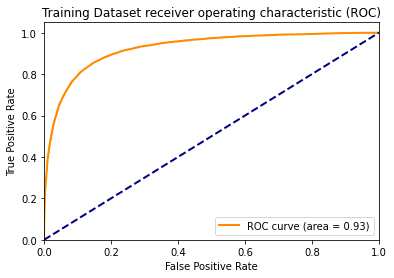

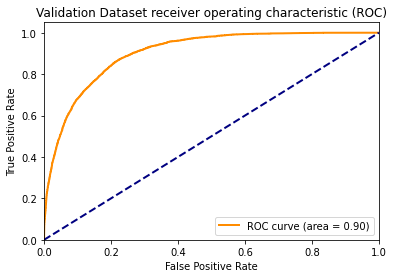

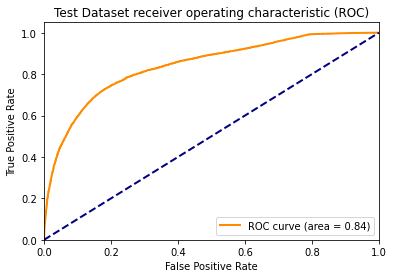

In [46]:
model.load_state_dict(torch.load("model.pt"))
evaluate_network(train_dataloader, model, "Training Dataset")
evaluate_network(valid_dataloader, model, "Validation Dataset")
evaluate_network(test_dataloader, model, "Test Dataset")